# K-means Clustering

## Introduction

K-means is an unsupervised learning algorithm used for clustering data points into $K$ groups. It's a popular method due to its simplicity and efficiency, especially for large datasets.

## Algorithm Overview

The K-means algorithm aims to partition $N$ data points into $K$ clusters, where each data point belongs to the cluster with the nearest mean (centroid). The algorithm alternates between two steps:

1. Assignment step: Assign each data point to the cluster with the nearest mean.
2. Update step: Recalculate the means (centroids) of each cluster.



## Mathematical Formulation

Let $\mathbf{X} = \{\mathbf{x}_1, \mathbf{x}_2, ..., \mathbf{x}_N\}$ be the set of N data points, where each $\mathbf{x}_i \in \mathbb{R}^D$ is a D-dimensional vector.

The goal is to find K cluster centroids $\{\boldsymbol{\mu}_1, \boldsymbol{\mu}_2, ..., \boldsymbol{\mu}_K\}$ that minimize the within-cluster sum of squares:

$$
J = \sum_{k=1}^K \sum_{\mathbf{x} \in C_k} \|\mathbf{x} - \boldsymbol{\mu}_k\|^2
$$

where $C_k$ is the set of points in cluster k.

## K-means Algorithm

1. Initialize K cluster centroids $\{\boldsymbol{\mu}_1, \boldsymbol{\mu}_2, ..., \boldsymbol{\mu}_K\}$.
2. Repeat until convergence:
   a. Assign each point to the nearest centroid:
      $$r_{nk} = \begin{cases} 1 & \text{if } k = \arg\min_j \|\mathbf{x}_n - \boldsymbol{\mu}_j\|^2 \\ 0 & \text{otherwise} \end{cases}$$
   b. Update centroids:
      $$\boldsymbol{\mu}_k = \frac{\sum_{n=1}^N r_{nk} \mathbf{x}_n}{\sum_{n=1}^N r_{nk}}$$



## Initialization Strategies

The performance of K-means can be sensitive to the initial choice of centroids. Three popular initialization methods are:

1. **Forgy initialization**: Randomly select K data points as initial centroids.
2. **Random partitioning**: Randomly assign each data point to one of K clusters, then compute initial centroids.
3. **K-means++ initialization**: This method aims to spread out the initial centroids:
   a. Choose the first centroid uniformly at random from the data points.
   b. For each subsequent centroid:
      - Compute the squared distance from each point to its nearest existing centroid.
      - Choose the next centroid with probability proportional to these squared distances.


## K-means++ Initialization

The K-means++ algorithm, introduced by Arthur and Vassilvitskii (2007), is an initialization method designed to improve the performance and convergence of the standard K-means algorithm. It addresses one of the main weaknesses of K-means: sensitivity to initial centroid placement.

### Motivation

In standard K-means, poor initialization can lead to suboptimal clustering results. K-means++ aims to choose initial centroids that are:
1. Well-spread throughout the dataset
2. Likely to be in different clusters

This approach tends to produce better clusterings and faster convergence compared to random initialization.

### Algorithm Details

Let $\mathbf{X} = \{\mathbf{x}_1, \mathbf{x}_2, ..., \mathbf{x}_N\}$ be the set of data points.

1. Choose the first centroid $\boldsymbol{\mu}_1$ uniformly at random from $\mathbf{X}$.

2. For $k = 2$ to $K$:
   a. Compute $D(\mathbf{x})$, the distance from each point to its nearest existing centroid:
      $$D(\mathbf{x}) = \min_{i=1}^{k-1} \|\mathbf{x} - \boldsymbol{\mu}_i\|$$
   
   b. Calculate the probability of selecting each point as the next centroid:
      $$P(\mathbf{x}) = \frac{D(\mathbf{x})^2}{\sum_{\mathbf{x}' \in \mathbf{X}} D(\mathbf{x}')^2}$$
   
   c. Choose the next centroid $\boldsymbol{\mu}_k$ randomly from $\mathbf{X}$ with probability proportional to $P(\mathbf{x})$.

3. Proceed with the standard K-means algorithm using these initial centroids.

### Key Insights

1. **Distance-based Probability**: Points farther from existing centroids have a higher probability of being chosen as the next centroid. This promotes diversity in centroid selection.

2. **Squared Distance**: Using $D(\mathbf{x})^2$ instead of $D(\mathbf{x})$ in the probability calculation further emphasizes the preference for distant points.

3. **Probabilistic Selection**: While favoring distant points, the method still allows for some randomness, potentially avoiding certain pathological datasets.

4. **Incremental Selection**: Centroids are chosen one at a time, with each choice influencing subsequent selections.

### Theoretical Guarantees

K-means++ provides theoretical guarantees on the quality of the initial clustering:

1. **Expected Approximation Ratio**: The expected value of the objective function (sum of squared distances) for the initial clustering is $O(\log K)$ competitive with the optimal K-means solution.

2. **Probability Bound**: With high probability, the initial clustering is $O(\log K)$-competitive with the optimal solution.

### Advantages

1. **Improved Initial Clustering**: Often starts with a configuration closer to the optimal solution.
2. **Faster Convergence**: Typically requires fewer iterations of the K-means algorithm to converge.
3. **Better Final Results**: Less likely to get stuck in poor local optima.
4. **Deterministic K-means Possible**: The good initialization allows for running K-means to convergence just once, instead of multiple runs with random restarts.

### Computational Considerations

1. **Time Complexity**: O(NK) distance calculations are required for initialization, which can be significant for large datasets.
2. **Space Complexity**: O(N) additional space to store distances/probabilities.

### Variants and Extensions

1. **K-means||**: A parallelized variant that selects O(K) candidates in each round, reducing the number of sequential operations.
2. **Adaptive K-means++**: Adjusts the number of clusters based on the data distribution during initialization.
3. **Weighted K-means++**: Incorporates sample weights into the initialization process.

By using K-means++ initialization, we can often achieve more reliable and efficient clustering results compared to standard random initialization methods. This improvement is especially valuable in applications where clustering quality is critical or computational resources are limited.

Evaluation of KMeans with k-means++ init
Evaluation of KMeans with random init
Evaluation of MiniBatchKMeans with k-means++ init
Evaluation of MiniBatchKMeans with random init


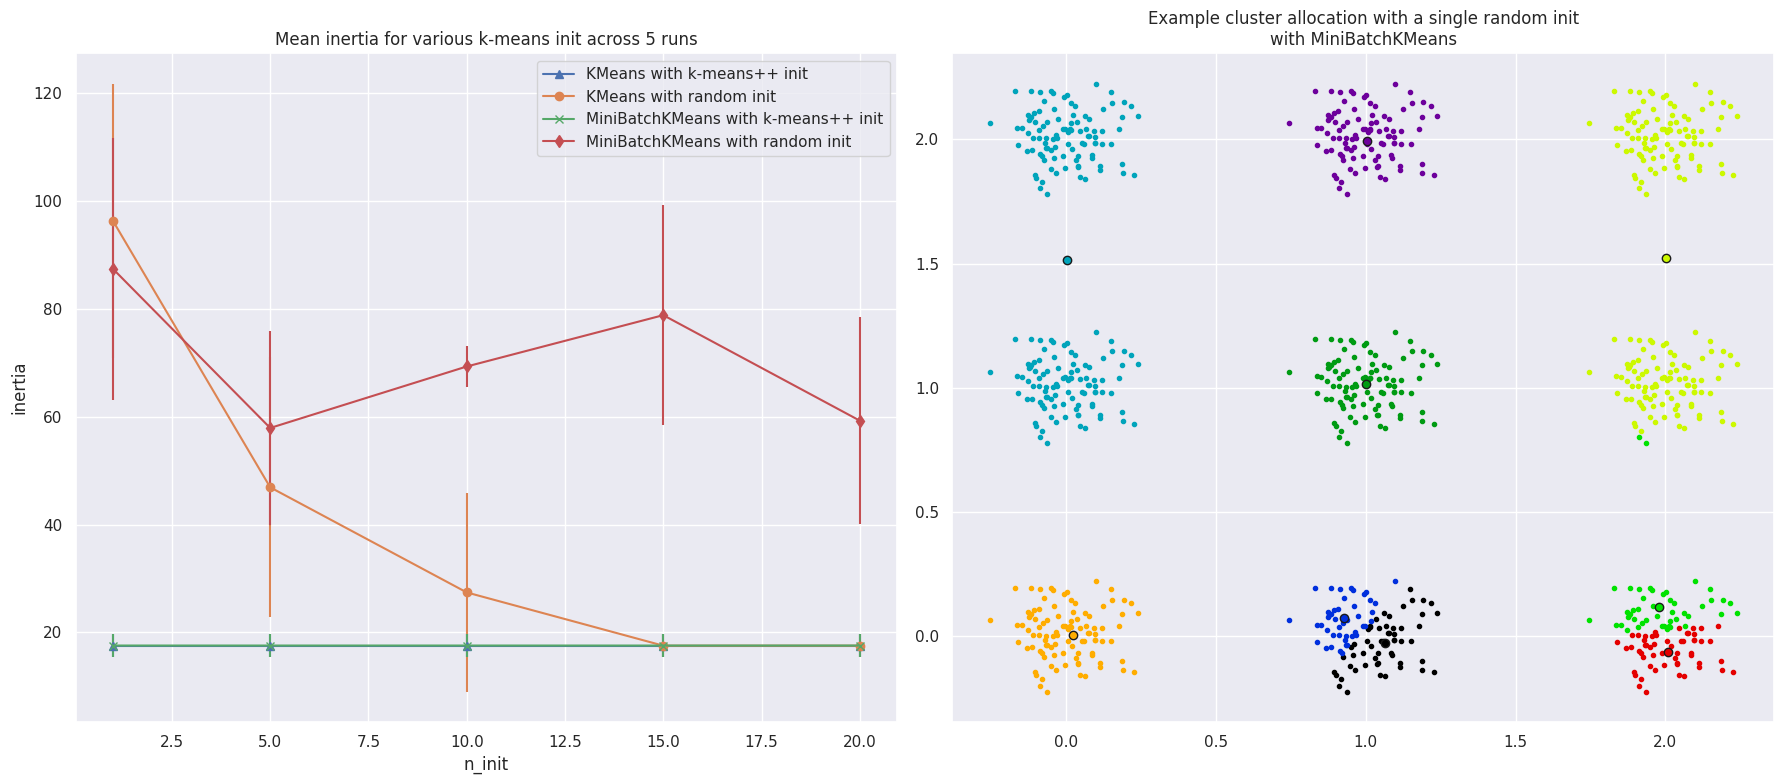

In [1]:
# Author: Olivier Grisel <olivier.grisel@ensta.org>
# License: BSD 3 clause

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_theme()

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.utils import check_random_state, shuffle

random_state = np.random.RandomState(0)

# Number of runs (with randomly generated datasets) for each strategy to
# compute an estimate of the standard deviation
n_runs = 5

# k-means models can do several random inits to trade
# CPU time for convergence robustness
n_init_range = np.array([1, 5, 10, 15, 20])

# Datasets generation parameters
n_samples_per_center = 100
grid_size = 3
scale = 0.1
n_clusters = grid_size**2

def make_data(random_state, n_samples_per_center, grid_size, scale):
    """
    Generates a dataset with clusters arranged in a grid pattern.
    
    Parameters:
    - random_state: a RandomState instance
    - n_samples_per_center: number of samples per cluster center
    - grid_size: size of the grid (grid_size x grid_size)
    - scale: standard deviation of the Gaussian noise added to the data
    
    Returns:
    - X: array of shape (n_samples, 2) with the generated samples
    - y: array of shape (n_samples,) with the cluster labels
    """
    random_state = check_random_state(random_state)
    centers = np.array([[i, j] for i in range(grid_size) for j in range(grid_size)])
    n_clusters_true, n_features = centers.shape

    noise = random_state.normal(scale=scale, size=(n_samples_per_center, centers.shape[1]))

    X = np.concatenate([c + noise for c in centers])
    y = np.concatenate([[i] * n_samples_per_center for i in range(n_clusters_true)])
    return shuffle(X, y, random_state=random_state)

# Create a single figure with one row and two columns
fig, axes = plt.subplots(1, 2, figsize=(18, 8), dpi=100)
plots = []
legends = []

# Part 1: Quantitative evaluation of various init methods

cases = [
    (KMeans, "k-means++", {}, "^-"),
    (KMeans, "random", {}, "o-"),
    (MiniBatchKMeans, "k-means++", {"max_no_improvement": 3}, "x-"),
    (MiniBatchKMeans, "random", {"max_no_improvement": 3, "init_size": 500}, "d-"),
]

for factory, init, params, format in cases:
    print("Evaluation of %s with %s init" % (factory.__name__, init))
    inertia = np.empty((len(n_init_range), n_runs))

    for run_id in range(n_runs):
        X, y = make_data(run_id, n_samples_per_center, grid_size, scale)
        for i, n_init in enumerate(n_init_range):
            km = factory(
                n_clusters=n_clusters,
                init=init,
                random_state=run_id,
                n_init=n_init,
                **params,
            ).fit(X)
            inertia[i, run_id] = km.inertia_
    p = axes[0].errorbar(
        n_init_range, inertia.mean(axis=1), inertia.std(axis=1), fmt=format
    )
    plots.append(p[0])
    legends.append("%s with %s init" % (factory.__name__, init))

axes[0].set_xlabel("n_init")
axes[0].set_ylabel("inertia")
axes[0].legend(plots, legends)
axes[0].set_title("Mean inertia for various k-means init across %d runs" % n_runs)

# Part 2: Qualitative visual inspection of the convergence

X, y = make_data(random_state, n_samples_per_center, grid_size, scale)
km = MiniBatchKMeans(
    n_clusters=n_clusters, init="random", n_init=1, random_state=random_state
).fit(X)

for k in range(n_clusters):
    my_members = km.labels_ == k
    color = cm.nipy_spectral(float(k) / n_clusters, 1)
    axes[1].plot(X[my_members, 0], X[my_members, 1], ".", c=color)
    cluster_center = km.cluster_centers_[k]
    axes[1].plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=color,
        markeredgecolor="k",
        markersize=6,
    )
axes[1].set_title(
    "Example cluster allocation with a single random init\nwith MiniBatchKMeans"
)

plt.tight_layout()
plt.show()



## K-means: Advantages and Challenges

Advantages:
- Simple and efficient for large datasets
- Guaranteed to converge (though possibly to a local optimum)

Challenges:
- Sensitive to initial centroid selection
- Number of clusters K must be specified in advance
- Assumes spherical clusters of similar size
- Sensitive to outliers



## Applications

K-means can be used for various tasks, including:
- Data compression (vector quantization)
- Feature learning
- Pre-processing for other algorithms

Fitting model on a small sub-sample of the data
done in 0.068s.
Predicting color indices on the full image (k-means)
done in 0.015s.
Predicting color indices on the full image (random)
done in 0.027s.


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


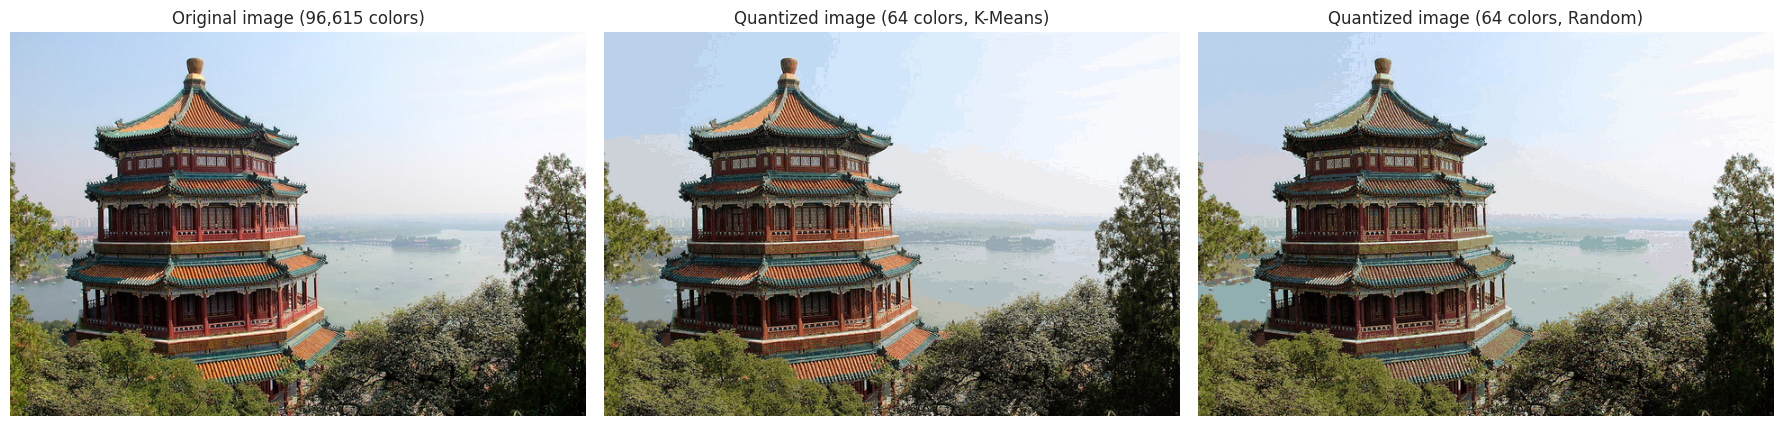

In [4]:
# Authors: Robert Layton <robertlayton@gmail.com>
#          Olivier Grisel <olivier.grisel@ensta.org>
#          Mathieu Blondel <mathieu@mblondel.org>
#
# License: BSD 3 clause

from time import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import load_sample_image
from sklearn.metrics import pairwise_distances_argmin
from sklearn.utils import shuffle

n_colors = 64

# Load the Summer Palace photo from sklearn's sample images
china = load_sample_image("china.jpg")

# Convert the image to floats instead of the default 8-bit integer coding.
# Dividing by 255 is important so that plt.imshow works well on float data 
# (values need to be in the range [0-1])
china = np.array(china, dtype=np.float64) / 255

# Get the dimensions of the image and reshape it to a 2D array.
w, h, d = original_shape = tuple(china.shape)
assert d == 3  # Ensure the image has 3 color channels (RGB)
image_array = np.reshape(china, (w * h, d))

# Fit the KMeans model on a small sub-sample of the data
print("Fitting model on a small sub-sample of the data")
t0 = time()
image_array_sample = shuffle(image_array, random_state=0, n_samples=1_000)
kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)
print(f"done in {time() - t0:0.3f}s.")

# Predict color indices on the full image using the fitted KMeans model
print("Predicting color indices on the full image (k-means)")
t0 = time()
labels = kmeans.predict(image_array)
print(f"done in {time() - t0:0.3f}s.")

# Generate a random codebook for comparison
codebook_random = shuffle(image_array, random_state=0, n_samples=n_colors)
print("Predicting color indices on the full image (random)")
t0 = time()
labels_random = pairwise_distances_argmin(codebook_random, image_array, axis=0)
print(f"done in {time() - t0:0.3f}s.")

def recreate_image(codebook, labels, w, h):
    """
    Recreate the (compressed) image from the codebook and labels.
    
    Parameters:
    - codebook: the colors assigned to each cluster
    - labels: the cluster labels for each pixel
    - w: the width of the original image
    - h: the height of the original image
    
    Returns:
    - Reconstructed image in its original shape.
    """
    return codebook[labels].reshape(w, h, -1)

# Display original and quantized images side by side for comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6), dpi=100)

# Display the original image
axes[0].imshow(china)
axes[0].set_title("Original image (96,615 colors)")
axes[0].axis("off")

# Display the K-Means quantized image
axes[1].imshow(recreate_image(kmeans.cluster_centers_, labels, w, h))
axes[1].set_title(f"Quantized image ({n_colors} colors, K-Means)")
axes[1].axis("off")

# Display the randomly quantized image
axes[2].imshow(recreate_image(codebook_random, labels_random, w, h))
axes[2].set_title(f"Quantized image ({n_colors} colors, Random)")
axes[2].axis("off")

plt.tight_layout()
plt.show()
